# Chapter 3: Designing LLM Evaluators

This code notebook is part of Chapter 3 lesson of the [LLM Apps: Evaluation course](https://wandb.ai/site/courses/evals/).
<a target="_blank" href="https://colab.research.google.com/github/wandb/eval-course/blob/main/notebooks/chapter_03_designing_and_improving.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<!--- @wandbcode{eval-course-03} -->

LLM evaluators utilize large language models as flexible, scalable evaluation tools, ideal for assessing complex and subjective tasks where traditional code-based methods may fall short. These evaluators can adapt to various contexts and criteria, making them valuable for evaluating nuanced outputs like creative writing, dialogue coherence, or complex problem-solving.

In this section, we’ll explore how to build an LLM evaluator from scratch. We’ll examine the essential components of an LLM evaluator and key considerations, such as defining clear criteria, designing effective prompts, and handling subjective judgments consistently.

## Setup

Run the code cells below to setup your colab notebook.

In [ ]:
!pip install -qq google-generativeai weave

In [ ]:
!git clone https://github.com/wandb/eval-course

import sys
sys.path.append("/content/eval-course/notebooks/utils/")

In [ ]:
import os
import re
import getpass
import weave
import pandas as pd

# utility script
from llm_client import LLMClient

import nest_asyncio
nest_asyncio.apply()

In [ ]:
import google.generativeai as genai

os.environ["GOOGLE_API_KEY"] = getpass.getpass("Please enter your GOOGLE API KEY with Gemini acccess: ")

In [ ]:
# initialize weave for tracing and evaluation
weave_client = weave.init(project_name="eval-course/eval-course")

## Essay Writer

Imagine you’re using an LLM to generate essays based on query in natural language.

LLM based essay write:

- Input: You start with a query, which is passed to an LLM-based essay writer.
- Output: The model generates an essay in response.

To evaluate the quality of these generated essays you already have a dataset where human evaluators have scored the essays based on specific criteria. More on it later.

Now, instead of relying solely on human evaluators, you want to build an LLM-based evaluator that can assess these essays automatically. This LLM evaluator should aim to mimic the judgments of human evaluators as closely as possible.


### Part 1: Prompt

An effective prompt for an LLM evaluator, or “judge,” requires careful design. This prompt typically has three essential components:

* **Task Description**: The task description sets the context for the LLM, clearly defining its role as an evaluator. This part should specify the nature of the content to be evaluated and the evaluator’s objective. For example, you might use:

  “*You are an evaluator tasked with assessing the fluency, coherence, and relevance of an essay based on a given query.*”
  
  This description helps the LLM understand its role and narrows its focus on evaluation, rather than content generation.

* **Measuring Criteria**: The criteria define what aspects of the content the LLM should evaluate. This could include specific elements such as fluency, grammar, factual accuracy, coherence, adherence to the prompt, etc. Clear criteria help the LLM understand what’s important and guide it to focus on the same standards human evaluators would. For example:

  “*The criteria for evaluation are: coherence (how logically ideas flow), grammar (correctness of language), factual accuracy (accuracy of statements), and adherence to the query prompt.*”
  
  These instructions give the LLM a structured lens through which to assess each aspect of the output.

* **Scoring Rubric**: The scoring rubric provides detailed guidelines on how to rate each criterion. This could include specific rating scales (e.g.,Likert Scale) or qualitative labels (e.g., “Excellent,” “Good,” “Needs Improvement”) that the LLM can use to categorize its evaluation. It’s often helpful to avoid numeric scores unless you’re confident the model can differentiate levels reliably. For instance:

 “*For each criterion, evaluate as follows: ‘Excellent’ if it fully meets expectations, ‘Satisfactory’ if it meets most expectations, and ‘Needs Improvement’ if it falls short.*”

 This rubric ensures consistency and makes the evaluation more interpretable by breaking down the scoring process.

In [ ]:
JUDGE_PROMPT = """You are an expert essay evaluator.
Please evaluate the following essay according to the "Holistic Rating for Source-Based Writing" rubric.

The essay is either "Excellent" or "Bad".
First give a reason for your judgement and return the result as a valid JSON object as shown below:

Examples:

```json
{{"score": "Excellent", "reason": "The essay demonstrates a clear understanding of the source text and effectively uses it to support its points."}}
```

```json
{{"score": "Bad", "reason": The essay is not clear and have grammatical errors"}}
```

Essay:
{full_text}
"""

### Part 2: The Evaluator

**[LLM SYSTEM] –> *system output* –> [EVALUATOR] –> evaluator output**

The LLM evaluator operates by taking in the prompt for evaluation (system prompt), initializing the LLM, and passing the system prompt along with the generated content—such as an essay—to the LLM for assessment.

We expect the evaluator to return a judgement which can be in the form of raw text or a JSON object.

Here we are using the `weave.Model` class which under the hood is a Pydantic `BaseModel`. By structuring your code to be compatible with this API, you benefit from a structured way to version your evaluator so you can more systematically keep track of your evaluations.

In this case, we are passing the `full_text` to the evaluator and expect it to return a JSON object with `score` and `reason` keys.

In [ ]:
MODEL = "gemini-2.0-flash-exp"
MODEL_CLIENT = "gemini"

In [ ]:
from weave import Model, Evaluation
import asyncio
import json


@weave.op()
def parse_json(result: str) -> dict:
    if "```json" in result:
        result = result.split("```json\n")[1].split("\n```")[0]
    # Clean up any remaining markdown formatting
    result = result.strip()
    return json.loads(result)


class EssayEvaluator(Model):
    model: LLMClient = LLMClient(model_name=MODEL, client_type=MODEL_CLIENT)
    judge_prompt: str = JUDGE_PROMPT

    @weave.op()
    def predict(self, full_text: str) -> dict:
        response = self.model.predict(self.judge_prompt.format(full_text=full_text))
        try:
            result = parse_json(response)
            return result
        except:
            return {"score": 0, "reason": "Failed to parse JSON"}  # Default to lowest score if parsing fails

# Initialize evaluator
essay_evaluator = EssayEvaluator()

### Part 3: The evaluation dataset

To simulate this imaginary scenario, we use a small subset of the `train.csv` file from the "[Learning Agency Lab - Automated Essay Scoring 2.0](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/data?select=train.csv)" Kaggle competition.

Specifically, we have two columns of interest: `full_text` and `score`. The `full_text` should be essay generated from our LLM based essay writer. The `score` is the score given by the human evaluators.

Each essay was scored on a scale of 1 to 6 using the "[Holistic Rating for Source-Based Writing](https://storage.googleapis.com/kaggle-forum-message-attachments/2733927/20538/Rubric_%20Holistic%20Essay%20Scoring.pdf)" code book. Scores 1-3 are considered "Bad" while the scores 4-6 are considered "Excellent". We are doing this for simplifying the interpretation of evaluation results. *Later we will use the actual scores.*


**What if I have to collect evaluation data in a similar scenario?**

Here are a few suggestions for a similar application (free-form generated content):

- **query-generated content**: start by collecting the query and the generated content. you can manually evaluate from here or do some interesting analysis to create synthetic evaluation set. We did something like this for our [wandbot](https://wandb.ai/wandbot/wandbot-eval/reports/How-to-Evaluate-an-LLM-Part-1-Building-an-Evaluation-Dataset-for-our-LLM-System--Vmlldzo1NTAwNTcy) (RAG application).

- **Read time tracking**: To understand user engagement, track the read time for each piece of generated content. For long-form outputs, you might want to record additional data such as scroll depth or even pauses in reading.

- **Track copied text**: Content that meets user needs and is of high quality may often be copied by the user. By logging instances of copied text, you can capture a direct measure of usefulness. Over time, this information helps build a dataset that reflects user interest and engagement, giving you a unique perspective on content effectiveness.


In [ ]:
# Load the dataset
essay_scorer_small = weave.ref(
    'weave:///eval-course/eval-course-dev/object/essay_scorer_small:8slEUgNXWoVhHAXksKXZPu5faasHshFksLXiD2haPSk'
).get()

### Part 4: The evaluation metric

We want to evaluate the evaluator's performance using the `score` column from the dataset - which contains human-assigned ratings. We are using the `exact_match` metric to check if the evaluator's prediction matches the human score.

Depending on the use case the metrics might change but in practice they are usually simple ad straightforward.

The `weave.op()` decorator allows us to track the metric as an operation in the weave graph. Here are a few [predefined metrics](https://weave-docs.wandb.ai/guides/evaluation/scorers#predefined-scorers) to take inspiration from.

In [ ]:
# Define a simple binary exact match metric
@weave.op()
def exact_match(score: int, output: dict) -> bool:
    """Check if predicted score matches human score"""
    if isinstance(output["score"], str):
      if score >= 1 and score <=3:
          return output["score"] == "Bad"
      else:
          return output["score"] == "Excellent"
    else:
      return output["score"] == score

### Part 5: The evaluation

Here are some essential features that make an evaluation system effective:

1. Asynchronous Processing
2. Trials and aggregated results
3. Powerful visualization
4. Evaluation comparison and insights

In [ ]:
# Create evaluation
evaluation = Evaluation(
    dataset=essay_scorer_small,
    scorers=[exact_match]
)

# Run evaluation
asyncio.run(evaluation.evaluate(essay_evaluator))

### Structured output (Optional)

Most frontier LLM providers support structured outputs. Using this forces the LLM to return/predict a specific schema.

Note: If you have complex "reasoning" to be done via your LLM evaluator, you should use two API calls. Use the first API call to do the reasoning and use the second API call to output the structured response. Reference: https://arxiv.org/abs/2408.02442v1

Learn more about structured outputs in this free course by Jason Liu: https://www.wandb.courses/courses/steering-language-models

In [ ]:
import typing
from pydantic import BaseModel

JUDGE_PROMPT = """You are an expert essay evaluator.
Please evaluate the following essay according to the "Holistic Rating for Source-Based Writing" rubric.

The essay is either "Excellent" or "Bad". Also give a reason for your judgement.
Essay:
{full_text}
"""

class Judgement(BaseModel):
    reason: str
    score: str


class EssayEvaluator(Model):
    model: LLMClient = LLMClient(model_name=MODEL, client_type=MODEL_CLIENT)
    judge_prompt: str = JUDGE_PROMPT
    response_schema: typing.Type[BaseModel] = Judgement

    @weave.op()
    def predict(self, full_text: str) -> dict:
        response = self.model.predict(
            self.judge_prompt.format(full_text=full_text),
            schema=self.response_schema,
        )
        try:
            return response[0]
        except:
            return {"score": 0, "reason": "Failed to parse JSON"}

# Initialize evaluator
essay_evaluator = EssayEvaluator()

# Run evaluation
asyncio.run(evaluation.evaluate(essay_evaluator))

# Aligning LLM evaluators with human evaluators

One of the most important aspects of building an LLM evaluator is to align it with human evaluators. This ensures that the evaluator is consistent with human beliefs ensuring higher confidence in the evaluator's predictions.

### Alignment is meta evaluation

A very important distinction, we need to make is that alignment is a way to **evaluate** the **evaluation system** itself. In this case the evaluation system is our *LLM Evaluator*.

Everytime, we talk about alignment know that the score is speaking something about the quality of LLM Evaluator.

### Why do we care about alignment?

Since we are using a non-deterministic machine (LLM) as the foundation of our evaluator, we need to be sure that the evaluator is as close as possible to aggregate human judgement.

A high alignment score gives the confidence in accepting/auditing the quality of our LLM system.

## The alignment metrics

### Alignment for binary decisions

#### Cohen's kappa

Fundamentally a correlation metric, it can be used to evaluate the agreement between our LLM evaluator and human scores. This metric is widely used to measure inter-rater reliability, and it accounts for the possibility of agreement occurring by chance unlike other correlation metrics.

**Cohen’s kappa** is a statistical measure of agreement that ranges from -1 to +1.

	•	+1 indicates perfect agreement between the evaluator and human ratings.
	•	0 represents the level of agreement expected by random chance.
	•	-1 implies complete disagreement, although values below zero are rare in practice.

This metric is particularly useful for evaluating classification tasks, as it provides a more robust measure of agreement than simple accuracy, especially when dealing with subjective assessments where some level of variance is expected.

#### Classification metrics

Your good old classification metrics like recall, precision, ROC, AUC, true positive, false positive, etc., are really strong metrics because of the ease of interpretation.

### Alignment for Likert Scale style decisions

When the decision is in a range (strongly agree - stongly disagree or 1-10), where the distance between ratings matters, **Kendall's tau and Spearman's rho** are more appropriate metrics because they both measure the rank order of the data. Kendall's tau focuses on whether pairs are in the same order, making it robust to outliers, while Spearman's rho is more sensitive to the size of rank differences.

Similarly values of these metrics are in a range of -1 to 1.

Example: If two teachers rate an essay as 4 and 3 on a 1-5 scale, Kendall’s tau  or Spearman’s rho  would recognize their close ranking, while Cohen’s kappa  would penalize them for not matching exactly.

### Why exact match cannot be used as an alignment score?

Exact match is actually computing the accuracy (comparing ground truth to predicted judgement). It treats all the classes as equal i.e, it is a coarse-grained measure of quality.

Also, real world distributions are not balanced making this is bad alignment metric.

In [ ]:
from utils import get_evaluation_predictions

# Get evaluation predictions
# Put in your own evaluation Call ID 👇
eval_df = get_evaluation_predictions(
    weave_client, eval_call_id="01942b5f-2c3a-7ce1-a716-7209bb2acd8f"
)

eval_df.head()

In [ ]:
from utils import calculate_cohen_kappa

# Calculate Cohen's Kappa score
kappa = calculate_cohen_kappa(eval_df, labels=[])
print(f"Alignment between human and LLM evaluator: {kappa:.3f}")

 Cohen kappa values of 0.21 - 0.40 can be interpreted as fair agreement while 0.41 - 0.60 suggest moderate agreement

## A single binary based evaluator will not capture the full extent of an evaluation task!

Evaluating a free-form content like essay needs to be evaluated across multiple axis.

A single "Bad" and "Excellent" judgement about the essay doesn't incite confidence in the quality (in this usecase). In practice, we need multiple evaluators that will access the essay for different attributes like - grammar, logical structure, pacing, flow, etc. These are all subjective criterias or abstract concepts that are hard to capture using programmatic evaluation. These evaluators looking at different attributes can have a binary decision rubric.

An aggregate of the judgements from different evaluators can determine the quality of the essay.

### Why binary evaluators?

If we can convert abstract concepts into mutliple "yes"/"no" objectives that a human can rate on, we **should build LLM based binary evaluators**.

The reason is ease of interpretation especially from the lens of alignment. False positive rate or recall can help coming up with actionable items.

### We are stuck with Likert scale based evaluator :)

In real life, the decision to design the evaluator can also be determined based on available human evaluation (annotations can be passively generated like read time, scroll depth, etc., or actively generated using a code book.) In our case, the essays are already annotated in a range of 1-6 (Likert Scale).

Let's see what evaluation score we get and the alignment score as well. We will be using the Kendall's tau alignment metric going forward.

In [ ]:
JUDGE_PROMPT = """You are an expert essay evaluator.
Please evaluate the following essay according to the "Holistic Rating for Source-Based Writing" rubric.

The scoring should be done in a range of 1-6 where 1 is a bad essay and 6 is an excellent essay.
Also give a reason for your judgement.

Essay:
{full_text}
"""

class Judgement(BaseModel):
    reason: str
    score: int

# Initialize evaluator
essay_evaluator = EssayEvaluator(
    judge_prompt=JUDGE_PROMPT, response_schema=Judgement
)

# Run evaluation
asyncio.run(evaluation.evaluate(essay_evaluator))

In [ ]:
from utils import calculate_kendall_tau

# Put in your own evaluation Call ID 👇
eval_df = get_evaluation_predictions(
    weave_client,
    "01942b62-2dd3-7703-b7e9-1aa7cb2597a0"
)

# Calculate Kendell's tau score
tau = calculate_kendall_tau(eval_df)

print(f"Alignment between human and LLM evaluator: {tau:.3f}")

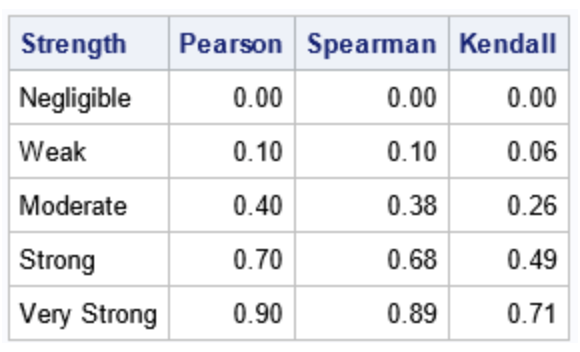

# Improving the LLM evaluator

## Part 1: Improve the criteria definition

Here we will improve the evaluator by improving the criteria used to evaluate the essays. Since the human annotators used the [Holistic Rating for Source-Based Writing](https://storage.googleapis.com/kaggle-forum-message-attachments/2733927/20538/Rubric_%20Holistic%20Essay%20Scoring.pdf)" code book we will use similar criteria to evaluate the essays.


In [ ]:
JUDGE_PROMPT = """You are an expert essay evaluator.
Please evaluate the following essay according to the "Holistic Rating for Source-Based Writing" rubric.

The scoring should be done in a range of 1-6 where a score of 1 represents minimal mastery,while a score
of 6 reflects outstanding performance. You are given a detailed scoring guideline below.

## SCORING CRITERIA:

```
Score 6: Demonstrates clear and consistent mastery with minor errors. Effectively and insightfully develops
a point of view with outstanding critical thinking. Uses appropriate examples and evidence to support its stance.
The essay is highly organized and coherent, showing smooth idea progression, skillful language use,
and varied, accurate vocabulary. Free of significant errors in grammar and mechanics.

Score 5: Shows reasonably consistent mastery with occasional errors. Develops a strong point of view with good
critical thinking, supported by relevant examples and evidence. Generally organized and coherent,
the essay uses language well, with appropriate vocabulary and sentence structure variety.
Mostly free of errors in grammar and mechanics.

Score 4: Demonstrates adequate mastery but has some lapses. Develops a point of view with competent critical thinking,
supported by adequate examples and evidence. Generally organized and coherent, though may show inconsistency
in language use or vocabulary choice. May have occasional grammar and mechanics errors.

Score 3: Shows developing mastery with weaknesses, such as inconsistent critical thinking or inadequate support.
Organization or focus may be limited, with possible lapses in coherence. Language use may be basic,
with weak vocabulary and/or issues in sentence structure. Contains multiple grammar and mechanics errors.

Score 2: Demonstrates little mastery and is flawed by vague or weak critical thinking, poor organization,
or insufficient evidence. Language use is limited, with frequent vocabulary and sentence structure issues.
Grammar and mechanics errors may obscure meaning.

Score 1: Displays very little or no mastery. Lacks a viable point of view or relevant evidence,
is highly disorganized or incoherent. Contains severe vocabulary and structure issues,
with pervasive grammar and mechanics errors that obscure meaning.
```

Use the scoring criteria to first reason about the quality of the provided essay and then give a score.

Essay:
{full_text}
""".strip()

# Initialize evaluator with the new JUDGE_PROMPT
essay_evaluator = EssayEvaluator(
    judge_prompt=JUDGE_PROMPT, response_schema=Judgement
)

# Run evaluation
asyncio.run(evaluation.evaluate(essay_evaluator))

In [ ]:
eval_df = get_evaluation_predictions(weave_client, "01942b63-dd5d-7ef0-8b7f-a75fe38e5e67")
tau = calculate_kendall_tau(eval_df)
print(f"Alignment between human and LLM evaluator: {tau:.3f}")

## Part 2: Add few-shot examples

Adding few-show examples can help the LLM evaluator understand the task better. It can help guide the LLM towards the correct answer.

In [ ]:
JUDGE_PROMPT = """You are an expert essay evaluator.
Please evaluate the following essay according to the "Holistic Rating for Source-Based Writing" rubric.

The scoring should be done in a range of 1-6 where a score of 1 represents minimal mastery,while a score
of 6 reflects outstanding performance. You are given a detailed scoring guideline below.

## SCORING CRITERIA:

```
Score 6: Demonstrates clear and consistent mastery with minor errors. Effectively and insightfully develops
a point of view with outstanding critical thinking. Uses appropriate examples and evidence to support its stance.
The essay is highly organized and coherent, showing smooth idea progression, skillful language use,
and varied, accurate vocabulary. Free of significant errors in grammar and mechanics.

Score 5: Shows reasonably consistent mastery with occasional errors. Develops a strong point of view with good
critical thinking, supported by relevant examples and evidence. Generally organized and coherent,
the essay uses language well, with appropriate vocabulary and sentence structure variety.
Mostly free of errors in grammar and mechanics.

Score 4: Demonstrates adequate mastery but has some lapses. Develops a point of view with competent critical thinking,
supported by adequate examples and evidence. Generally organized and coherent, though may show inconsistency
in language use or vocabulary choice. May have occasional grammar and mechanics errors.

Score 3: Shows developing mastery with weaknesses, such as inconsistent critical thinking or inadequate support.
Organization or focus may be limited, with possible lapses in coherence. Language use may be basic,
with weak vocabulary and/or issues in sentence structure. Contains multiple grammar and mechanics errors.

Score 2: Demonstrates little mastery and is flawed by vague or weak critical thinking, poor organization,
or insufficient evidence. Language use is limited, with frequent vocabulary and sentence structure issues.
Grammar and mechanics errors may obscure meaning.

Score 1: Displays very little or no mastery. Lacks a viable point of view or relevant evidence,
is highly disorganized or incoherent. Contains severe vocabulary and structure issues,
with pervasive grammar and mechanics errors that obscure meaning.
```

## EXAMPLES:

Here are a few essays and the scores given by human evaluators with a reason.
Use these essays to guide your own evaluation decisions.

{few_shot_examples}

Use the scoring criteria and few examples to first reason about the quality of the provided essay and then give a score.

Essay:
{full_text}
""".strip()

In [ ]:
# load few shot examples

essay_few_shot_examples = weave.ref(
    "weave:///eval-course/eval-course-dev/object/essay_few_shot_examples:JOwkagw7bMwqGobX1hOAIQFmQnofVEOZz7lbU54WYVw"
).get()

few_shot_examples_str = "\n\n".join([
    f"Essay:\n{row['essay']}\n\n{json.dumps(dict(score=row['score'], reason=row['reason']))}"
    for row in essay_few_shot_examples.rows
])

In [ ]:
class EssayEvaluator(Model):
    model: LLMClient = LLMClient(model_name=MODEL, client_type=MODEL_CLIENT)
    judge_prompt: str = JUDGE_PROMPT
    response_schema: typing.Type[BaseModel] = Judgement

    @weave.op()
    def predict(self, full_text: str) -> dict:
        response = self.model.predict(
            self.judge_prompt.format(few_shot_examples=few_shot_examples_str, full_text=full_text),
            schema=self.response_schema,
        )
        try:
            return response[0]
        except:
            return {"score": 0, "reason": "Failed to parse JSON"}

In [ ]:
# Initialize evaluator with the new JUDGE_PROMPT
essay_evaluator = EssayEvaluator()

# Run evaluation
asyncio.run(evaluation.evaluate(essay_evaluator))

In [ ]:
eval_df = get_evaluation_predictions(weave_client, "01942b66-17be-7013-a85c-389ec3f3bae3")
tau = calculate_kendall_tau(eval_df)
print(f"Alignment between human and LLM evaluator: {tau:.3f}")